# Project Group - 22

Members: Charlotte Koning, Cleo Vos, Koen Awater, Jasmijn van de Kar, Jippo Steenstra

Student numbers: 5414164, 5324599, 5416493, 5315611, 5064740

# Introduction

Every five years, SAIL Amsterdam attracts millions of visitors to the city’s waterfront for one of the world’s largest tall ship events. While the celebration showcases the Netherlands’ maritime heritage, it also poses significant logistical challenges: large, fluctuating and not easily predictable pedestrian flows must be managed without compromising safety or the functioning of surrounding transport systems. Anticipating where and when peaks occur is therefore crucial for maintaining public safety and accessibility.

This project investigates to what extent anomalous peaks in pedestrian flow can be predicted up to 15 minutes in advance using historical sensor data and temporal features. We develop and evaluate machine-learning approaches—such as XGBoost and Random Forest to deliver short-horizon alerts of impending anomalies.

The report documents the full pipeline, from data selection and preprocessing to model training and evaluation and assesses which method gives the most accurate and timely anomaly predictions. The findings aim to support a data-driven operational workflow for real-time crowd monitoring which coulf have been used during SAIL 2025, helping authorities optimize staffing, steer pedestrian routing and reduce overcrowding risk. The results will contribute to a more data-driven and resilient approach to crowd management for SAIL's next edition and similar large-scale public events.

# Research Objective

Our main research question is:

To what extent can anomalous peaks in pedestrian flow be predicted up to 15 minutes in advance using historical sensor data and temporal features?

To answer this research question we will look into dataset [1], the SAIL2025 LVMA pedestrian-flow dataset, which contains 3-minute resolution counts from multiple sensors across the SAIL Amsterdam event area for 20–25 August 2025. We formulate a 15-minute-ahead anomaly prediction task for this. In order to fully answer the research question, we created sub questions, listed below.  

Sub questions:
1.	How can anomalous crowd behaviour be quantitatively defined within the dataset?
2.	Which sensor locations show the highest likelihood of anomalies?
3.	How accurately can different models (e.g., Logistic Regression, Random Forest, XGBoost) predict anomalies?
4.	Which features (temporal, spatial, or meteorological) contribute most to prediction accuracy?

[1] 'SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv'

# Contribution Statement

Be specific. Some of the tasks can be coding (expect everyone to do this), background research, conceptualisation, visualisation, data analysis, data modelling

Charlotte Koning: coding,

Cleo Vos: coding,

Jasmijn van de Kar: coding,

Jippo Steenstra: coding,

Koen Awater: coding,

# Data Used

The data used for this project was obtained from the faculty, called 'SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv' and 'sensor-location.xlsx'. 

All figures and graphs which are used in the report are created by using the provided data.

The dataset exhibits a clear daily cycle, with sensors showing similar behaviour and peaks occurring at roughly the same times. Therefore we made predictions combining multiple days for a more accurate prediction. Since the data per sensor was also behaving similarly, we fltered the data to only 3 sensors instead of 36 to give a clearer and better outline. To make sure the sensors represent the SAIL area correctly, the three loactions of the chosen sensors are quick different.  

# Data Pipeline

For the geographical scale we will use eastern harbor of Amsterdam IJhaven, across the IJ river. The temporal scale of the project will be the 20-24 august 2025. For data preperation we will use the Panda library in python.

1.⁠ ⁠Sources: How is our data source categorized and what does our data consist of? 
2.⁠ ⁠Data processing: How is our data converted to data we could use? 
3.⁠ ⁠Destination: What data is used for the making of the graphs? How can the data be used now? 

*Datafile 1: Sail crowd flows*  
\
This datafile holds the data on the crowdflows per sensor during sail. Each sensor measured the number of people passing every three minutes. 

*Data formatting*  
The data is turned into a pandas dataframe so that the file can be read and further used in python. Encoding is automatically detected with chardet. From this dataset the time features are selected and with these features a subset is made along with the selected sensors. This results in a dataset with three sensors and their time features. 

\
*Data processing*: 
From the data the averages per hour and averages per weekday are calculated. The result of this data formatting and processing is a flow-table with timefeatures and sensordata which is used for visualisatoin, peak-detection and forecasting.

Datafile 2: Sensorlocation
This datafile holds the location of each sensor. These are the sensors which are used in the the other datafile on crowdflows. 

Data formatting 
The file is an excel-file and is turned into a pandas dataframe with a chardet-encoding.

In [19]:
import pandas as pd
import chardet
import os
import matplotlib.pyplot as plt
import calendar
import numpy as np
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import find_peaks
from collections import deque
import sklearn

In [20]:
flow_file = 'SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv'
location_file = 'sensor-location.xlsx'

with open(flow_file, 'rb') as f:
    result = chardet.detect(f.read())

enc = result['encoding']

df_flow = pd.read_csv(flow_file, encoding=enc)


with open(location_file, 'rb') as f:
    result = chardet.detect(f.read())


df_location = pd.read_excel(location_file)

To do: Filter data to only a few sensors

In [21]:
df_flow.head(3)


,timestamp,CMSA-GAKH-01_0,CMSA-GAKH-01_180,CMSA-GAWW-11_120,CMSA-GAWW-11_300,CMSA-GAWW-12_115,CMSA-GAWW-12_295,CMSA-GAWW-13_120,CMSA-GAWW-13_300,CMSA-GAWW-14_40,...,GVCV-13_10,GVCV-13_190,GVCV-14_90,GVCV-14_270,hour,minute,day,month,weekday,is_weekend
0,2025-08-20 00:00:00+02:00,15,4,29,33,44,28,42,37,11,...,41,40,0,0,0,0,20,8,2,0
1,2025-08-20 00:03:00+02:00,1,3,21,29,34,39,9,14,6,...,0,0,0,0,0,3,20,8,2,0
2,2025-08-20 00:06:00+02:00,5,4,35,22,29,34,33,42,14,...,0,0,0,0,0,6,20,8,2,0


In [22]:
sensors = ["GVCV-13_10","CMSA-GAWW-12_295", "CMSA-GAKH-01_0"]
date_time = ["timestamp", "hour", "minute", "day", "weekday", "is_weekend"]
df_three_sensors = df_flow[date_time + sensors].copy()
df_three_sensors.head()

,timestamp,hour,minute,day,weekday,is_weekend,GVCV-13_10,CMSA-GAWW-12_295,CMSA-GAKH-01_0
0,2025-08-20 00:00:00+02:00,0,0,20,2,0,41,28,15
1,2025-08-20 00:03:00+02:00,0,3,20,2,0,0,39,1
2,2025-08-20 00:06:00+02:00,0,6,20,2,0,0,34,5
3,2025-08-20 00:09:00+02:00,0,9,20,2,0,0,40,4
4,2025-08-20 00:12:00+02:00,0,12,20,2,0,127,33,4


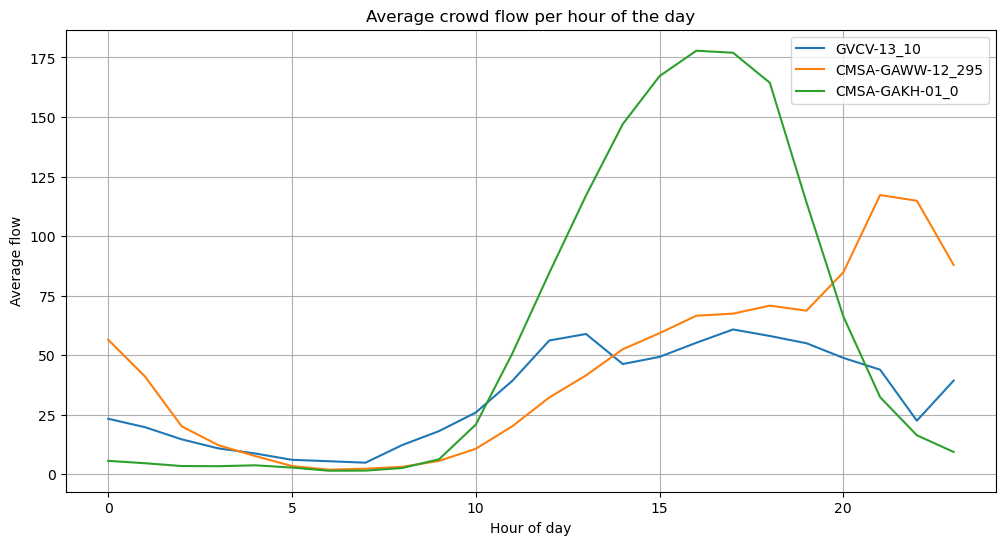

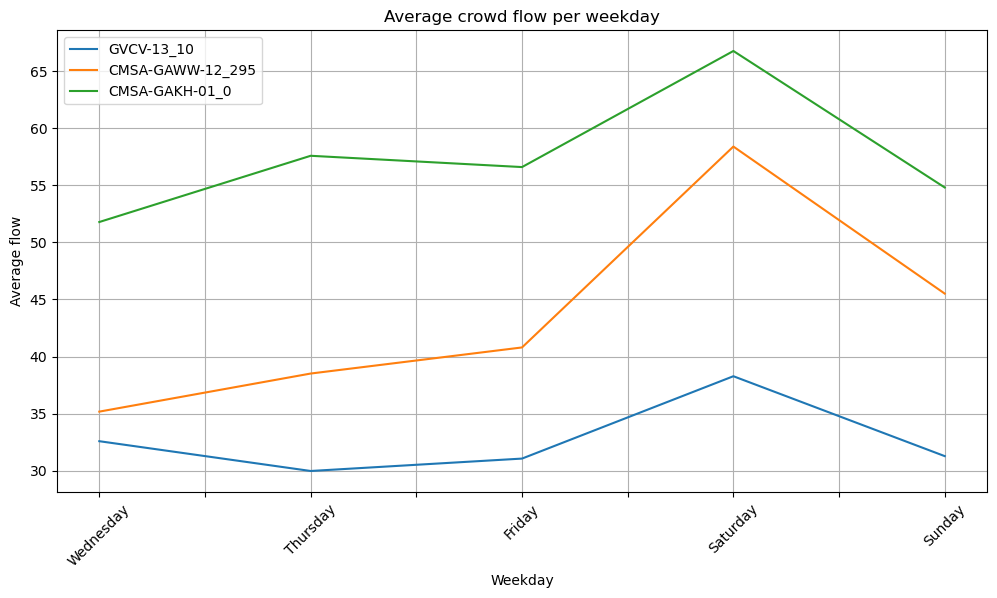

In [23]:
# plot 1: average crowd flow count per hour of the day
plt.figure(figsize=(12, 6))

for sensor in sensors:
    df_three_sensors.groupby("hour")[sensor].mean().plot(label=sensor)
plt.title("Average crowd flow per hour of the day")
plt.xlabel("Hour of day")
plt.ylabel("Average flow")
plt.legend()
plt.grid(True)
plt.show()

# plot 2: average crowd flow count per day
weekday_names = [calendar.day_name[i] for i in range(7)]

plt.figure(figsize=(12, 6))
for sensor in sensors:
    weekday_means = df_three_sensors.groupby("weekday")[sensor].mean()
    weekday_means.index = [weekday_names[i] for i in weekday_means.index]
    weekday_means.plot(label=sensor)

plt.title("Average crowd flow per weekday")
plt.xlabel("Weekday")
plt.ylabel("Average flow")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

The graphs above show the average crowd flow per hour of the day and per day of the week for three selected sensors located in different areas of the SAIL event site. From the first graph, it becomes clear that the dataset exhibits a clear daily pattern, with flow levels rising sharply during late morning and afternoon hours and decreasing again in the evening. Although the absolute flow differs per location, the sensors show similar behaviour with peaks occurring at approximately the same times, indicating consistent crowd dynamics across the event area.

The second graph illustrates the average crowd flow per weekday, showing that weekends, particularly Saturday, experience the highest activity across all sensors. This confirms that visitor intensity increases toward the weekend. 

Even though the data period is limited to five days (the lenght of the SAIL event), these patterns suggest that both time of day and day of week are strong predictors of crowd intensity. Hence, temporal features such as hour and weekday are expected to contribute significantly to the model’s ability to forecast anomalous peaks in pedestrian flow.

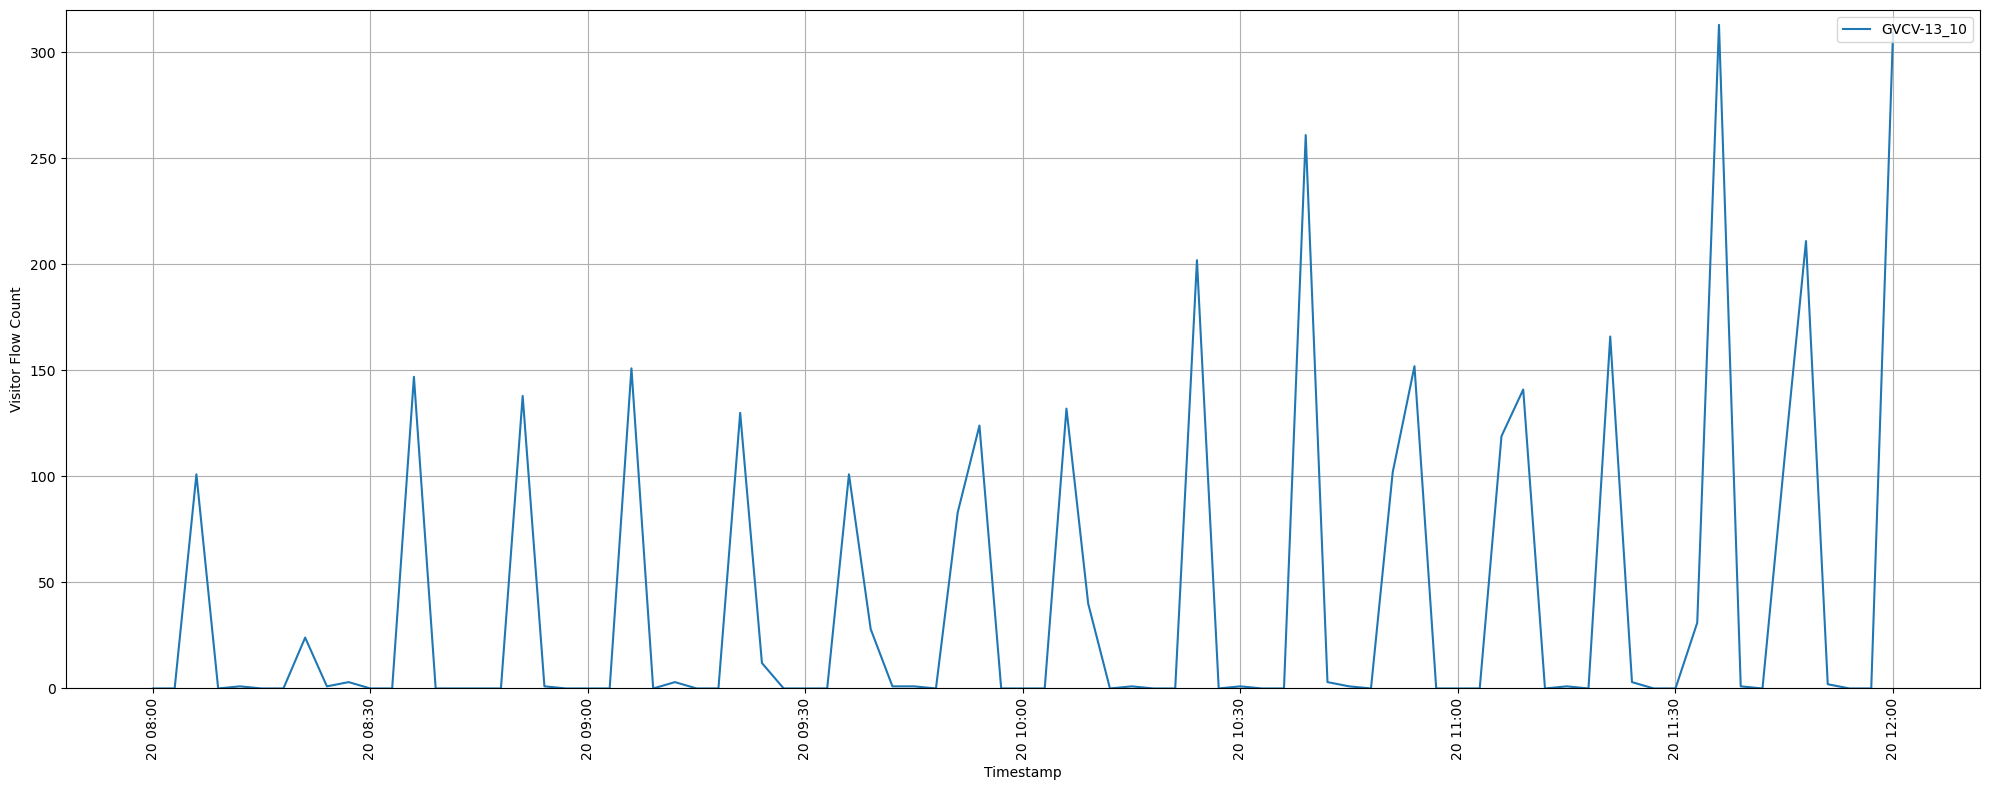

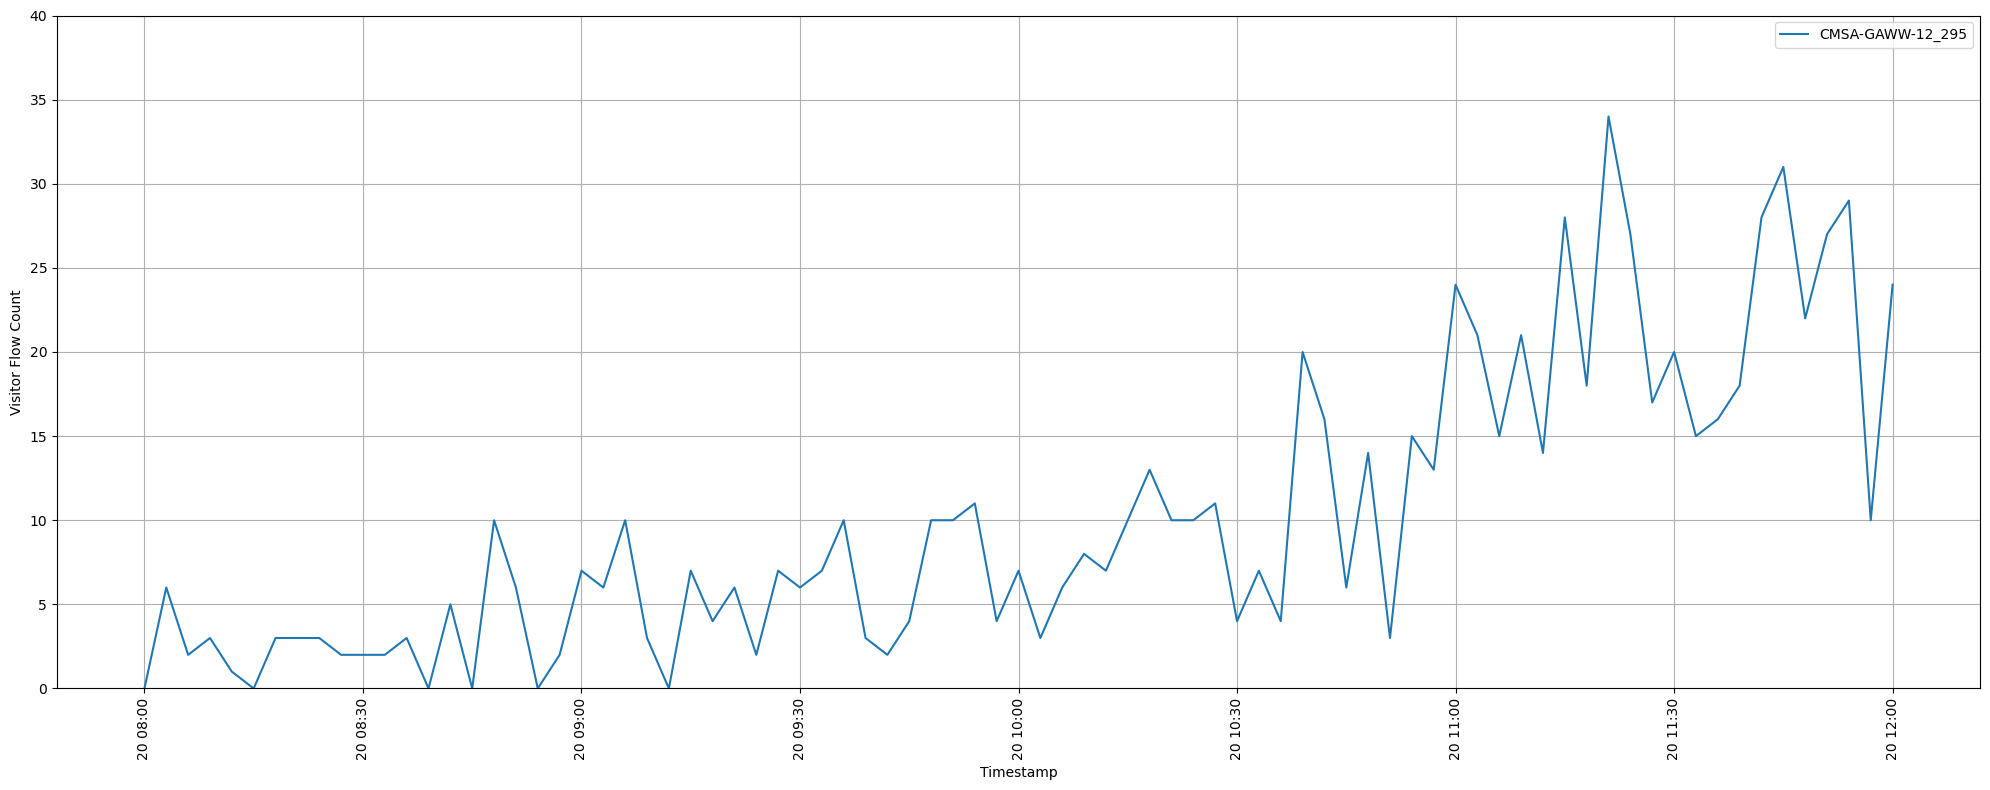

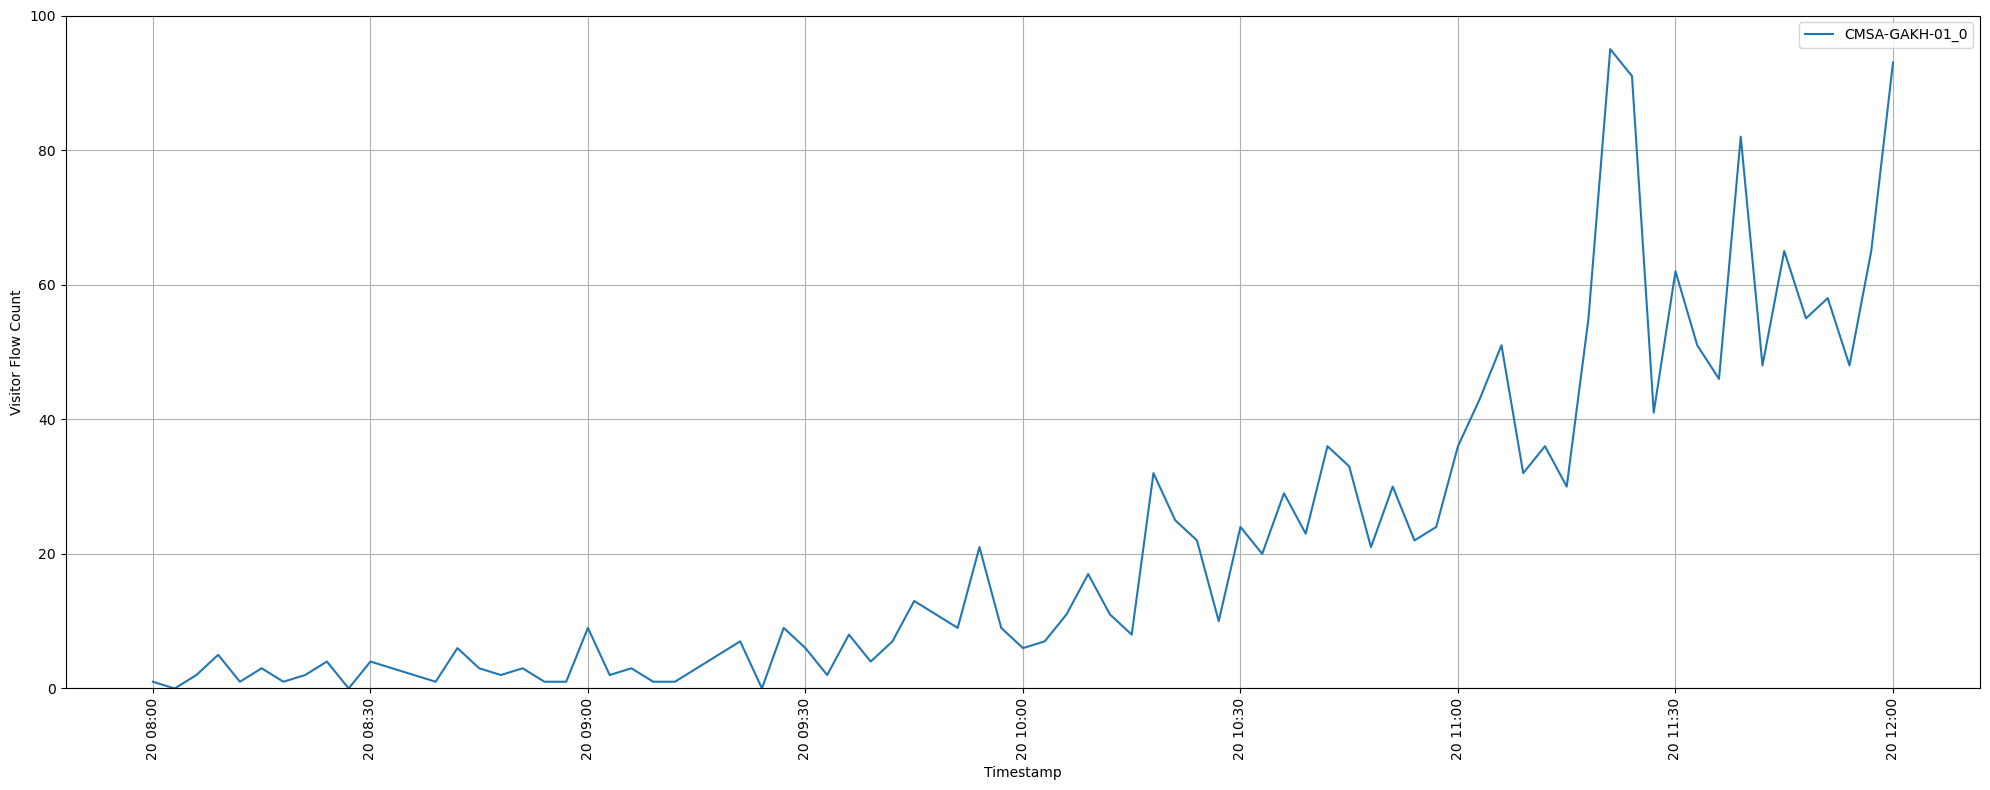

In [24]:
df_flow["timestamp"] = pd.to_datetime(df_flow["timestamp"])
df_flow = df_flow.sort_values("timestamp")

# check if sensors exist in df_flow columns
for sensor in sensors:
    if sensor not in df_flow.columns:
        print(f"Warning: sensor '{sensor}' not found in df_flow columns, skipping.")
        continue

    series = df_flow.set_index("timestamp")[sensor].resample("3min").mean()

    # pick first day (20, wednesday) and window 08:00-12:00
    day0 = series.index.normalize()[0]
    start = day0 + pd.Timedelta(hours=8)
    end   = day0 + pd.Timedelta(hours=12)
    window = series.loc[start:end]

    plt.figure(figsize=(20, 8))
    plt.plot(window.index, window.values, label=sensor, linewidth=1.5)
    plt.xlabel("Timestamp")
    plt.ylabel("Visitor Flow Count")
    plt.xticks(rotation=90)

    ymax = 20 * int(np.ceil((np.nanmax(window.values) if np.isfinite(np.nanmax(window.values)) else 0) / 20.0))
    plt.ylim(0, max(20, ymax))

    plt.grid(True)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


A rolling MAD (Median Absolute Deviation) is then used to estimate the local variability (σ), giving a robust measure of short-term noise. Points are considered significant only if they exceed ±3 × σ from the baseline:
	•	resid > +3σ → candidate peak
	•	resid < −3σ → candidate trough

Using scipy.signal.find_peaks, the algorithm marks only those points that are local maxima or minima satisfying these thresholds. Finally, any extrema closer than 6 samples apart are filtered so that only the strongest event in each cluster remains.

In summary, a peak is a point that rises more than three times the local noise above its short-term baseline and stands out as a local maximum; a trough is the mirror case below the baseline.

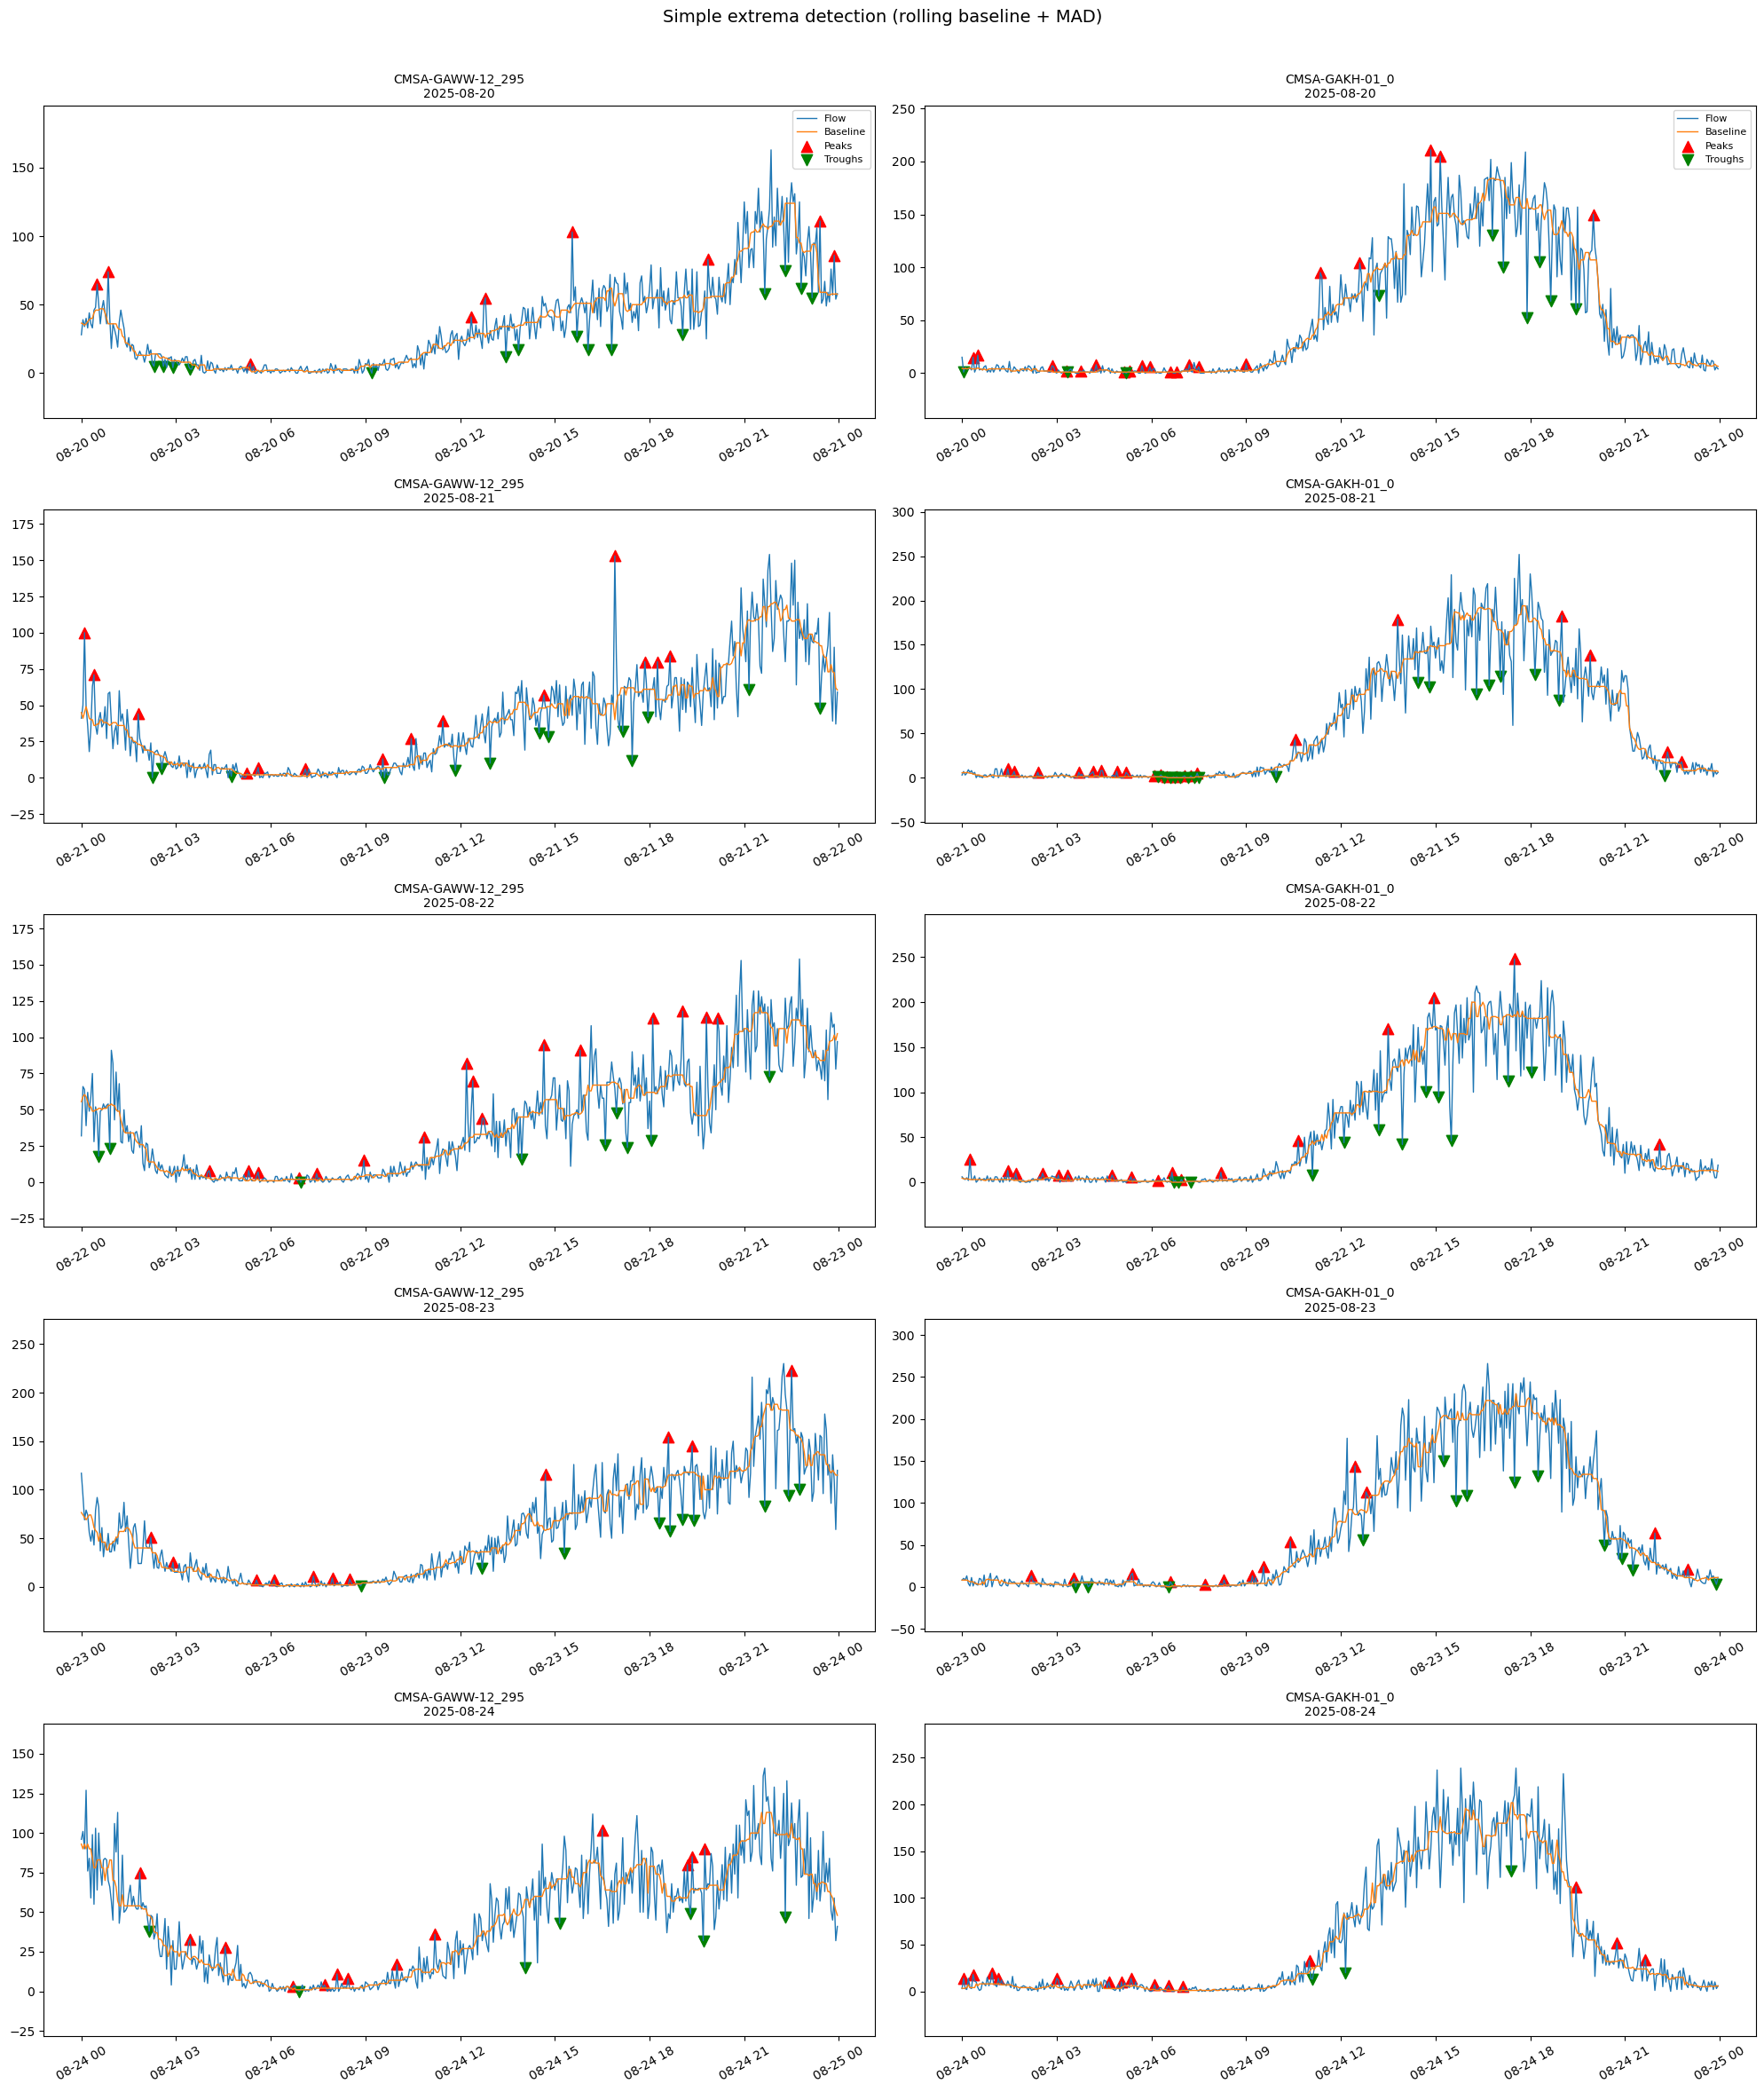

In [25]:
# ---- Simple knobs ----
WIN        = 11   # rolling window (samples) for baseline & scale
K_SIGMA    = 3  # threshold in "sigma" units for extrema
MIN_DIST   = 3    # min distance between extrema (samples)

def rolling_mad_sigma(resid: pd.Series, win: int) -> pd.Series:
    # robust rolling sigma via MAD; fall back to global median if needed
    def _mad(a):
        m = np.median(a)
        return 1.4826 * np.median(np.abs(a - m))
    sig = resid.rolling(win, center=True, min_periods=1).apply(_mad, raw=True)
    return sig.fillna(sig.median())

def simple_extrema(y: pd.Series, win=WIN, k=K_SIGMA, min_dist=MIN_DIST):
    """
    Returns (peaks_idx, troughs_idx, baseline) using one rolling baseline
    and one rolling MAD-based sigma. Peaks = resid > k*sigma & local max,
    Troughs = resid < -k*sigma & local min.
    """
    baseline = y.rolling(win, center=True, min_periods=1).median()
    resid    = y - baseline
    sigma    = rolling_mad_sigma(resid, win)

    # Peaks on +resid above +k*sigma
    pk, _ = find_peaks(resid.to_numpy(),
                       height=(k * sigma.to_numpy()),
                       distance=min_dist)

    # Troughs on -resid above +k*sigma  <=> resid < -k*sigma
    tr, _ = find_peaks((-resid).to_numpy(),
                       height=(k * sigma.to_numpy()),
                       distance=min_dist)

    return pk, tr, baseline

# ---------- Example usage in your per-day/per-sensor loop ----------
# (assumes df with columns: 'timestamp', sensor names, already sorted)

sensors2 = ["CMSA-GAWW-12_295", "CMSA-GAKH-01_0"]
df_three_sensors["timestamp"] = pd.to_datetime(df_three_sensors["timestamp"])
days = sorted(df_three_sensors["timestamp"].dt.date.unique())[:5]

fig, axes = plt.subplots(len(days), len(sensors2), figsize=(20, 24))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, day in enumerate(days):
    mask = df_three_sensors["timestamp"].dt.date == day
    t    = df_three_sensors.loc[mask, "timestamp"].reset_index(drop=True)

    for j, s in enumerate(sensors2):
        ax = axes[i, j]
        y  = df_three_sensors.loc[mask, s].astype(float).reset_index(drop=True)

        pk, tr, base = simple_extrema(y)

        ax.plot(t, y, lw=1, label="Flow")
        ax.plot(t, base, lw=1, alpha=1, label="Baseline")
        if len(pk): ax.scatter(t.iloc[pk], y.iloc[pk], s=80, color= "red", marker="^", label="Peaks")
        if len(tr): ax.scatter(t.iloc[tr], y.iloc[tr], s=80, color= "green", marker="v", label="Troughs")

        # a bit of headroom so peaks are visible
        y_min, y_max = y.min(), y.max()
        pad = 0.2 * max(1e-9, y_max - y_min)
        ax.set_ylim(y_min - pad, y_max + pad)

        ax.set_title(f"{s}\n{day}", fontsize=10)
        ax.tick_params(axis="x", rotation=30)
        if i == 0: ax.legend(fontsize=8)

plt.suptitle("Simple extrema detection (rolling baseline + MAD)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The figure above presents the detected pedestrian flow peaks for two sensors during the five event days. Each subplot shows the measured flow at 3 minute resolution represented by a blue line. While the red dots indicate peak moments. 

The plots reveal several notable patterns. All sensors display a daily rhythm, with low activity during the morning hours and increasing pedestrian volumes throughout the afternoon and evening. The peaks occur around similar times on multiple days. Indicating recurring crowd flows, which may be linked to the scheduled events. Furthermore, senor CMSA-GAKH-01_0 consistently records higher and more freqeunt peals than CMSA-GAWW-12_295. This suggests that it is located at a more prominent location, experiencing heavier pedestrian volumes.

Despite daily variations, the algorithm reliably identifies both major and minor peaks. Showing that the method works well across different sensors and days Overall, this visualisation validates the anomaly labeling approach, confirming that the dataset captures meaningful pedestrian flow peaks suitable for predictive modeling. 

sklearn version: 1.7.2


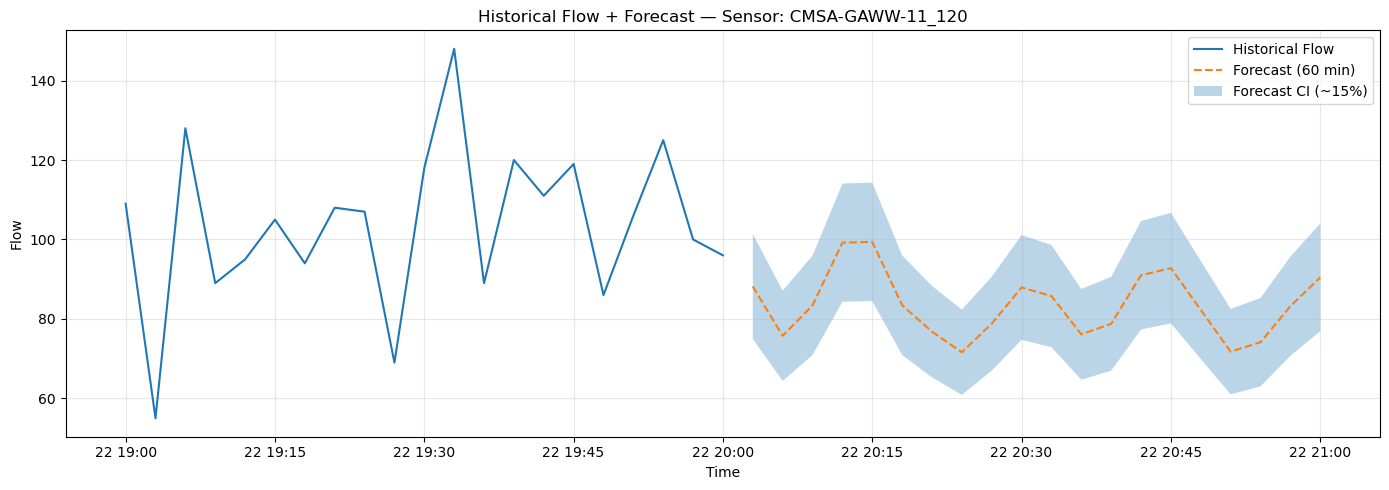

In [26]:
# ==============================
# 1) Feature/Train set builder
# ==============================
def build_training_set(df, sensor, FREQ_MIN=3,
                       LAGS=(1,2,3,4,5,10,20), ROLLS=(5,10,20),
                       HORIZON_STEPS=1):
    """
    Maakt features voor one-step-ahead (default 1 stap = FREQ_MIN minuten).
    Retourneert X, y, feature_cols, Xy (met tijdkolom), HORIZON_STEPS, data_original
    """
    TIME_COL = "timestamp"
    df = df.sort_values(TIME_COL).copy()
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True).dt.tz_convert(None)
    data = df[[TIME_COL, sensor]].rename(columns={sensor: "count"}).dropna()

    def add_features(x):
        x = x.copy()
        x["hour"] = x[TIME_COL].dt.hour
        x["dow"]  = x[TIME_COL].dt.dayofweek
        x["sin_hour"] = np.sin(2*np.pi*x["hour"]/24)
        x["cos_hour"] = np.cos(2*np.pi*x["hour"]/24)
        x["sin_dow"]  = np.sin(2*np.pi*x["dow"]/7)
        x["cos_dow"]  = np.cos(2*np.pi*x["dow"]/7)

        # lags
        for L in LAGS:
            x[f"lag_{L}"] = x["count"].shift(L)

        # rollings (op vorige waarden)
        for w in ROLLS:
            rsrc = x["count"].shift(1).rolling(w, min_periods=1)
            x[f"roll_mean_{w}"] = rsrc.mean()
            x[f"roll_std_{w}"]  = rsrc.std(ddof=0)
            x[f"roll_max_{w}"]  = rsrc.max()

        # piek-signaal features
        x["delta1"] = x["count"].diff(1).fillna(0.0)
        x["delta2"] = x["delta1"].diff(1).fillna(0.0)
        x["roll_max_3"] = x["count"].shift(1).rolling(3, min_periods=1).max()
        x["roll_q90_9"] = x["count"].shift(1).rolling(9, min_periods=1).quantile(0.9)

        # target 1 stap vooruit
        x["y_horizon"] = x["count"].shift(-HORIZON_STEPS)
        return x

    Xy = add_features(data)
    need_cols = [f"lag_{L}" for L in LAGS] + ["y_horizon"]
    Xy = Xy.dropna(subset=need_cols).reset_index(drop=True)

    # kolommen voor het model
    base_feats = [c for c in Xy.columns if c.startswith(("lag_","roll_","sin_","cos_"))]
    extra_feats = ["delta1","delta2","roll_max_3","roll_q90_9"]
    feature_cols = [c for c in base_feats + extra_feats if c in Xy.columns]

    X = Xy[feature_cols].values
    y = Xy["y_horizon"].values
    return X, y, feature_cols, Xy, HORIZON_STEPS, data

# ==============================
# 2) Poisson-trainer (fallback naar quantile)
# ==============================
def train_peak_model(X, y, Xy_train, random_state=42, use_peak_weights=True):
    """
    Probeert HGBR met loss='poisson'. Valt terug op
    GradientBoostingRegressor met quantile-loss als het niet kan.
    """
    assert (y >= 0).all(), "Poisson/quantile verwachten niet-negatieve counts."

    # gewichten om pieken nadruk te geven (optioneel)
    sample_weight = None
    if use_peak_weights:
        base = Xy_train["count"].rolling(20, min_periods=1).mean()
        dev  = (Xy_train["count"] - base).clip(lower=0)
        w = 1.0 + (dev / (dev.std() + 1e-6))
        sample_weight = np.asarray(w[:len(y)], dtype=float)

    # Probeer Poisson HGBR; als niet beschikbaar of training faalt -> fallback
    try:
        model = HistGradientBoostingRegressor(
            loss="poisson",
            learning_rate=0.05,
            max_iter=500,
            max_depth=None,
            max_bins=255,
            min_samples_leaf=20,
            early_stopping=True,
            validation_fraction=0.1,
            l2_regularization=0.0,
            random_state=random_state,
        )
        model.fit(X, y, sample_weight=sample_weight)
        return model
    except TypeError:
        pass  # loss-parameter niet ondersteund in deze sklearn
    except Exception:
        pass  # training faalde; gebruik fallback

    # Fallback: quantile modellen (median + hoge kwantiel) en blenden richting bovenkant
    q_hi = GradientBoostingRegressor(
        loss="quantile", alpha=0.90,
        n_estimators=600, learning_rate=0.03, max_depth=3,
        random_state=random_state
    ).fit(X, y)

    q_med = GradientBoostingRegressor(
        loss="quantile", alpha=0.50,
        n_estimators=600, learning_rate=0.03, max_depth=3,
        random_state=random_state
    ).fit(X, y)

    class BlendModel:
        def __init__(self, base, hi, w_hi=0.7):
            self.base, self.hi, self.w_hi = base, hi, float(w_hi)
        def predict(self, X_):
            p_base = self.base.predict(X_)
            p_hi   = self.hi.predict(X_)
            extra  = np.maximum(0.0, p_hi - p_base)
            return np.clip(p_base + self.w_hi * extra, 0.0, None)

    return BlendModel(q_med, q_hi, w_hi=0.7)

# ==============================
# 3) Forecast met correcte lag/rolling buffer
# ==============================
def plot_recursive_forecast1(df, model, sensor, target_time,
                             FREQ_MIN=3, forecast_minutes=60,
                             LAGS=(1,2,3,4,5,10,20), ROLLS=(5,10,20),
                             HORIZON_STEPS=1):
    """
    One-step (HORIZON_STEPS=1) recursieve forecast.
    Past elke stap ALLE lags/rollings opnieuw aan via een buffer.
    """
    TIME_COL = "timestamp"

    # ---- voorbereiden ----
    df = df.sort_values(TIME_COL).copy()
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True).dt.tz_convert(None)
    data = df[[TIME_COL, sensor]].rename(columns={sensor: "count"}).dropna()

    def add_features(x):
        x = x.copy()
        x["hour"] = x[TIME_COL].dt.hour
        x["dow"]  = x[TIME_COL].dt.dayofweek
        x["sin_hour"] = np.sin(2*np.pi*x["hour"]/24)
        x["cos_hour"] = np.cos(2*np.pi*x["hour"]/24)
        x["sin_dow"]  = np.sin(2*np.pi*x["dow"]/7)
        x["cos_dow"]  = np.cos(2*np.pi*x["dow"]/7)
        for L in LAGS:
            x[f"lag_{L}"] = x["count"].shift(L)
        for w in ROLLS:
            rsrc = x["count"].shift(1).rolling(w, min_periods=1)
            x[f"roll_mean_{w}"] = rsrc.mean()
            x[f"roll_std_{w}"]  = rsrc.std(ddof=0)
            x[f"roll_max_{w}"]  = rsrc.max()
        x["delta1"] = x["count"].diff(1).fillna(0.0)
        x["delta2"] = x["delta1"].diff(1).fillna(0.0)
        x["roll_max_3"] = x["count"].shift(1).rolling(3,1).max()
        x["roll_q90_9"] = x["count"].shift(1).rolling(9,1).quantile(0.9)
        x["y_horizon"] = x["count"].shift(-HORIZON_STEPS)
        return x

    Xy = add_features(data).dropna(subset=[f"lag_{L}" for L in LAGS] + ["y_horizon"]).reset_index(drop=True)
    feature_cols = [c for c in Xy.columns if c.startswith(("lag_","roll_","sin_","cos_"))] \
                 + ["delta1","delta2","roll_max_3","roll_q90_9"]
    feature_cols = [c for c in feature_cols if c in Xy.columns]

    # ---- startpunt dichtst bij target_time ----
    target_time = pd.Timestamp(target_time)
    idx = (Xy[TIME_COL] - target_time).abs().idxmin()
    last_row = Xy.iloc[idx].copy()
    start_time = last_row[TIME_COL]

    # ---- buffers met recente historie ----
    max_win = max(max(LAGS), max(ROLLS), 3, 9)
    hist_tail = Xy["count"].iloc[max(0, idx - max_win + 1): idx + 1].tolist()
    buf = deque(hist_tail, maxlen=max_win)

    # ---- recursie ----
    step_minutes = HORIZON_STEPS * FREQ_MIN  # 1 stap = 3 min
    forecast_steps = max(1, forecast_minutes // step_minutes)
    forecast_values, forecast_times = [], []

    for _ in range(forecast_steps):
        # bouw features uit buffer
        for L in LAGS:
            last_row[f"lag_{L}"] = (buf[-L] if len(buf) >= L else np.nan)
        for w in ROLLS:
            window = list(buf)[-w:]
            last_row[f"roll_mean_{w}"] = float(np.mean(window))
            last_row[f"roll_std_{w}"]  = float(np.std(window, ddof=0))
            last_row[f"roll_max_{w}"]  = float(np.max(window))
        # piek-features
        arr = np.array(buf, dtype=float)
        delta1 = arr[-1] - arr[-2] if len(arr) >= 2 else 0.0
        delta2 = (arr[-1] - arr[-2]) - (arr[-2] - arr[-3]) if len(arr) >= 3 else 0.0
        last_row["delta1"] = float(delta1)
        last_row["delta2"] = float(delta2)
        last_row["roll_max_3"] = float(np.max(arr[-3:])) if len(arr) >= 1 else float(arr[-1])
        last_row["roll_q90_9"] = float(np.quantile(arr[-9:], 0.9)) if len(arr) >= 1 else float(arr[-1])

        # predict
        X_step = last_row[feature_cols].values.reshape(1, -1)
        pred = float(model.predict(X_step)[0])
        pred = max(0.0, pred)

        next_time = last_row[TIME_COL] + pd.Timedelta(minutes=step_minutes)
        forecast_times.append(next_time)
        forecast_values.append(pred)

        # schuif vooruit
        last_row[TIME_COL] = next_time
        last_row["count"]  = pred
        buf.append(pred)

    # CI (simpele band)
    forecast_values = np.array(forecast_values, dtype=float)
    ci = 0.15 * forecast_values
    lower = forecast_values - ci
    upper = forecast_values + ci

    # plot 1 uur historie + forecast
    one_hour_before = start_time - pd.Timedelta(hours=1)
    historical_zoom = Xy[(Xy[TIME_COL] >= one_hour_before) & (Xy[TIME_COL] <= start_time)]

    plt.figure(figsize=(14,5))
    plt.plot(historical_zoom[TIME_COL], historical_zoom["count"], label="Historical Flow")
    plt.plot(forecast_times, forecast_values, linestyle="--", label=f"Forecast ({forecast_minutes} min)")
    plt.fill_between(forecast_times, lower, upper, alpha=0.3, label="Forecast CI (~15%)")
    plt.xlabel("Time"); plt.ylabel("Flow")
    plt.title(f"Historical Flow + Forecast — Sensor: {sensor}")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ==============================
# 4) Voorbeeldgebruik (pas aan)
# ==============================
print("sklearn version:", sklearn.__version__)

SENSOR_COL   = "CMSA-GAWW-11_120"   # <-- wijzig naar jouw sensornaam
FREQ_MIN     = 3
LAGS         = (1,2,3,4,5,10,20)
ROLLS        = (5,10,20)
HORIZON_STEPS = 1  # one-step-ahead (3 minuten)

# Bouw trainset
X, y, feature_cols, Xy_train, H, data_used = build_training_set(
    df_flow, SENSOR_COL, FREQ_MIN=FREQ_MIN, LAGS=LAGS, ROLLS=ROLLS, HORIZON_STEPS=HORIZON_STEPS
)

# Train Poisson (of fallback blend)
model = train_peak_model(X, y, Xy_train, use_peak_weights=True)

# Plot forecast (bijv. 60 minuten vanaf target)
plot_recursive_forecast1(
    df=df_flow,
    model=model,
    sensor=SENSOR_COL,
    target_time="2025-08-22 20:00:00",  # kies een tijd in jouw data
    forecast_minutes=60,
    FREQ_MIN=FREQ_MIN, LAGS=LAGS, ROLLS=ROLLS, HORIZON_STEPS=H
)

This graph shows both historical pedestrian flow and the the short term forecast for sensor CMSA-GAWW-11_120. The blue line represents the observed flow up to 20:00, the orange dashed line indicated the models predicted flow for the next 60 minutes. The forecast confidence interval is shown by the shaded blue area, indicating the expected range of future values. 

In [27]:
def plot_recursive_forecast2(df, model, sensor, target_time,
                            FREQ_MIN=3, forecast_minutes=60,
                            LAGS=(1,2,3,4,5,10,20), ROLLS=(5,10,20),
                            HORIZON_STEPS=1):
    """
    One-step (HORIZON_STEPS=1) recursieve forecast.
    Plot: 1h historie + forecast + CI + daadwerkelijke toekomstige data.
    """

    TIME_COL = "timestamp"

    # ---- voorbereiden ----
    df = df.sort_values(TIME_COL).copy()
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], utc=True).dt.tz_convert(None)
    data = df[[TIME_COL, sensor]].rename(columns={sensor: "count"}).dropna()

    def add_features(x):
        x = x.copy()
        x["hour"] = x[TIME_COL].dt.hour
        x["dow"]  = x[TIME_COL].dt.dayofweek
        x["sin_hour"] = np.sin(2*np.pi*x["hour"]/24)
        x["cos_hour"] = np.cos(2*np.pi*x["hour"]/24)
        x["sin_dow"]  = np.sin(2*np.pi*x["dow"]/7)
        x["cos_dow"]  = np.cos(2*np.pi*x["dow"]/7)
        for L in LAGS:
            x[f"lag_{L}"] = x["count"].shift(L)
        for w in ROLLS:
            rsrc = x["count"].shift(1).rolling(w, min_periods=1)
            x[f"roll_mean_{w}"] = rsrc.mean()
            x[f"roll_std_{w}"]  = rsrc.std(ddof=0)
            x[f"roll_max_{w}"]  = rsrc.max()
        # piekfeatures
        x["delta1"] = x["count"].diff(1).fillna(0.0)
        x["delta2"] = x["delta1"].diff(1).fillna(0.0)
        x["roll_max_3"] = x["count"].shift(1).rolling(3,1).max()
        x["roll_q90_9"] = x["count"].shift(1).rolling(9,1).quantile(0.9)
        x["y_horizon"] = x["count"].shift(-HORIZON_STEPS)
        return x

    Xy = add_features(data).dropna(subset=[f"lag_{L}" for L in LAGS] + ["y_horizon"]).reset_index(drop=True)
    feature_cols = [c for c in Xy.columns if c.startswith(("lag_","roll_","sin_","cos_"))] \
                 + ["delta1","delta2","roll_max_3","roll_q90_9"]
    feature_cols = [c for c in feature_cols if c in Xy.columns]

    # ---- startpunt (dichtsbij target_time) ----
    target_time = pd.Timestamp(target_time)
    idx = (Xy[TIME_COL] - target_time).abs().idxmin()
    last_row = Xy.iloc[idx].copy()
    start_time = last_row[TIME_COL]

    # ---- buffer met recente historie ----
    max_win = max(max(LAGS), max(ROLLS), 3, 9)
    hist_tail = Xy["count"].iloc[max(0, idx - max_win + 1): idx + 1].tolist()
    buf = deque(hist_tail, maxlen=max_win)

    # ---- recursie ----
    step_minutes = HORIZON_STEPS * FREQ_MIN  # 1 stap = 3 min
    forecast_steps = max(1, forecast_minutes // step_minutes)
    forecast_values, forecast_times = [], []

    for _ in range(forecast_steps):
        # features uit buffer
        for L in LAGS:
            last_row[f"lag_{L}"] = (buf[-L] if len(buf) >= L else np.nan)
        for w in ROLLS:
            window = list(buf)[-w:]
            last_row[f"roll_mean_{w}"] = float(np.mean(window))
            last_row[f"roll_std_{w}"]  = float(np.std(window, ddof=0))
            last_row[f"roll_max_{w}"]  = float(np.max(window))
        arr = np.array(buf, dtype=float)
        last_row["delta1"] = float(arr[-1] - arr[-2]) if len(arr) >= 2 else 0.0
        last_row["delta2"] = float((arr[-1]-arr[-2]) - (arr[-2]-arr[-3])) if len(arr) >= 3 else 0.0
        last_row["roll_max_3"] = float(np.max(arr[-3:])) if len(arr) else 0.0
        last_row["roll_q90_9"] = float(np.quantile(arr[-9:], 0.9)) if len(arr) else 0.0

        # predict
        features = last_row[feature_cols].values.reshape(1, -1)
        pred = max(0.0, float(model.predict(features)[0]))

        next_time = last_row[TIME_COL] + pd.Timedelta(minutes=step_minutes)
        forecast_times.append(next_time)
        forecast_values.append(pred)

        # vooruit schuiven
        last_row[TIME_COL] = next_time
        last_row["count"]  = pred
        buf.append(pred)

    # ---- CI (nu: vaste ±15%) ----
    forecast_values = np.array(forecast_values, dtype=float)
    ci = 0.15 * forecast_values
    lower = forecast_values - ci
    upper = forecast_values + ci

    # ---- historie + daadwerkelijke toekomst binnen horizon ----
    one_hour_before = start_time - pd.Timedelta(hours=1)
    end_time = start_time + pd.Timedelta(minutes=forecast_minutes)

    historical_zoom = data[(data[TIME_COL] >= one_hour_before) & (data[TIME_COL] <= start_time)]
    future_truth = data[(data[TIME_COL] > start_time) & (data[TIME_COL] <= end_time)]

    # ---- plot ----
    plt.figure(figsize=(14,5))
    plt.plot(historical_zoom[TIME_COL], historical_zoom["count"], label="Historical Flow")
    if not future_truth.empty:
        plt.plot(future_truth[TIME_COL], future_truth["count"], label="Actual Future", linewidth=2)
    plt.plot(forecast_times, forecast_values, linestyle="--", label=f"Forecast ({forecast_minutes} min)")
    plt.fill_between(forecast_times, lower, upper, alpha=0.3, label="Forecast CI (~15%)")

    plt.xlabel("Time"); plt.ylabel("Flow")
    plt.title(f"Historical Flow + Forecast vs Actual — Sensor: {sensor}")
    plt.legend(); plt.grid(alpha=0.3)

    # x-as exact op jouw horizon
    ax = plt.gca()
    ax.set_xlim(start_time - pd.Timedelta(hours=1),
                start_time + pd.Timedelta(minutes=forecast_minutes))

    plt.tight_layout(); plt.show()

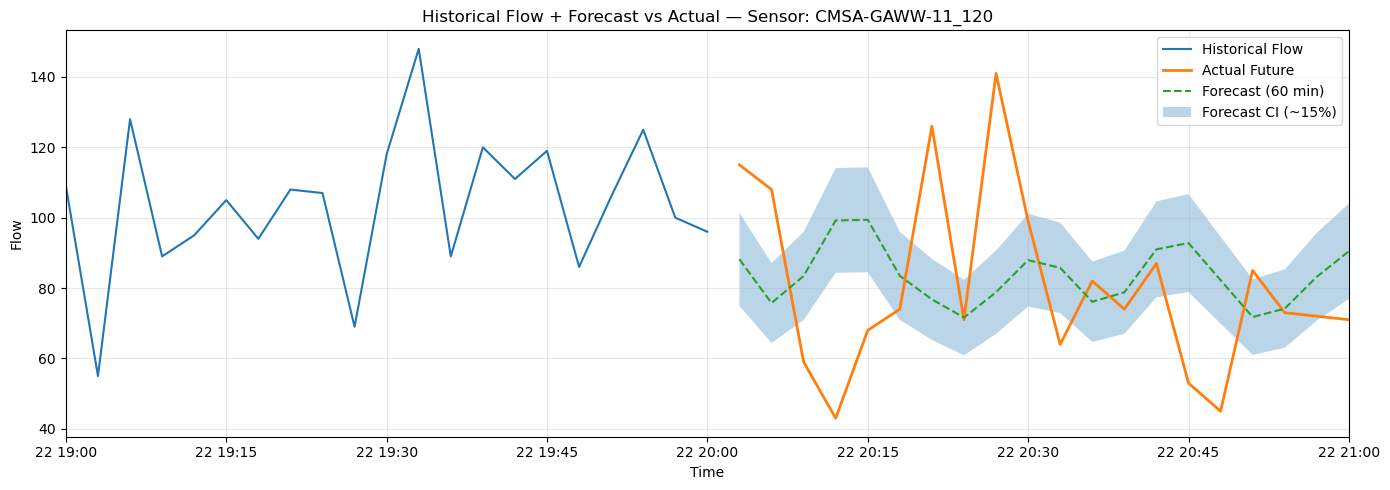

In [28]:
plot_recursive_forecast2(
    df=df_flow,
    model=model,
    sensor=SENSOR_COL,
    target_time="2025-08-22 20:00:00",  # kies een tijd in jouw data
    forecast_minutes=60,
    FREQ_MIN=FREQ_MIN, LAGS=LAGS, ROLLS=ROLLS, HORIZON_STEPS=H
)

In this graph the actual future measurements, indicated by the orange line, are revealed. The models forecast can be compared with the reality. In this case, the forecast does not follow the actual future measurements. The model predicted relatively stable flow values, while the true observations fluctuate. This includes several sudden peaks that the model fails to anticipate.

# Conclusion